# ***1. Import Necessary Libraries***


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import tensorflow as tf
import keras
import cv2
import random
import shutil

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import MobileNet

# ***2. FER2013 and AffectNet downloaded from Kaggle and extracted ***

In [4]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d msambare/fer2013
!kaggle datasets download -d noamsegal/affectnet-training-data

#Extract FER
with zipfile.ZipFile('fer2013.zip', 'r') as zip_ref:
    zip_ref.extractall('fer2013')

# Check the extracted files
for root, dirs, files in os.walk('fer2013'):
    for file in files:
        print(os.path.join(root, file))


# Extract AffectNet
with zipfile.ZipFile('affectnet-training-data.zip', 'r') as zip_ref:
    zip_ref.extractall('affectnet')


for root, dirs, files in os.walk('affectnet'):
    for file in files:
        print(os.path.join(root, file))



Streaming output truncated to the last 5000 lines.
affectnet/sad/image0022928.jpg
affectnet/sad/image0029166.jpg
affectnet/sad/image0026321.jpg
affectnet/sad/image0028583.jpg
affectnet/sad/image0026306.jpg
affectnet/sad/image0010653.jpg
affectnet/sad/image0028195.jpg
affectnet/sad/image0005175.jpg
affectnet/sad/image0021349.jpg
affectnet/sad/image0029531.jpg
affectnet/sad/image0000093.jpg
affectnet/sad/image0007355.jpg
affectnet/sad/image0018394.jpg
affectnet/sad/image0027320.jpg
affectnet/sad/image0019092.jpg
affectnet/sad/image0019097.jpg
affectnet/sad/image0029535.jpg
affectnet/sad/image0030252.jpg
affectnet/sad/image0012466.jpg
affectnet/sad/image0021104.jpg
affectnet/sad/image0029937.jpg
affectnet/sad/image0013199.jpg
affectnet/sad/image0001842.jpg
affectnet/sad/image0013878.jpg
affectnet/sad/image0021219.jpg
affectnet/sad/image0024693.jpg
affectnet/sad/image0020917.jpg
affectnet/sad/image0013792.jpg
affectnet/sad/image0021849.jpg
affectnet/sad/image0026960.jpg
affectnet/sad/image

# ***3. AffectNet Preprocessing***

In order to make AffectNet similar to FER2013, some operations was made.

*  Contempt, disgust and surprised emotions are not included. Anger, fear, happy, neutral and sad are kept.
*   Images resized 48x48 pixels from 96x96 pixels.

*   Converted grayscale from RGB.

*   Splitted test and train folders with a ratio of 0.8.

*  Shuffled to create a random distrubition.




In [5]:
# Define the emotions to keep and their mappings
affectnet_emotions_to_keep = ['anger', 'happy', 'neutral', 'sad']
emotion_mapping = {
    'anger': 'angry',
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad'
}

# Preprocess AffectNet (resize, convert grayscale, split, shuffle)
def preprocess_affectnet_images(src_dir, train_dir, test_dir, target_size=(48, 48), split_ratio=0.8):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for emotion in affectnet_emotions_to_keep:
        class_dir = os.path.join(src_dir, emotion)
        train_class_dir = os.path.join(train_dir, emotion_mapping[emotion])
        test_class_dir = os.path.join(test_dir, emotion_mapping[emotion])

        if not os.path.exists(train_class_dir):
            os.makedirs(train_class_dir)
        if not os.path.exists(test_class_dir):
            os.makedirs(test_class_dir)

        files = os.listdir(class_dir)
        random.shuffle(files)
        split_point = int(len(files) * split_ratio)

        for img_name in tqdm(files[:split_point], desc=f'Processing {emotion} - Train'):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = cv2.resize(gray_img, target_size)
            cv2.imwrite(os.path.join(train_class_dir, img_name), resized_img)

        for img_name in tqdm(files[split_point:], desc=f'Processing {emotion} - Test'):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = cv2.resize(gray_img, target_size)
            cv2.imwrite(os.path.join(test_class_dir, img_name), resized_img)

# Paths
affectnet_src_dir = "affectnet/"
affectnet_train_preprocessed_dir = "affectnet_preprocessed/train/"
affectnet_test_preprocessed_dir = "affectnet_preprocessed/test/"

# Preprocess AffectNet images
preprocess_affectnet_images(affectnet_src_dir, affectnet_train_preprocessed_dir, affectnet_test_preprocessed_dir)

Processing sad - Test: 100%|██████████| 619/619 [00:00<00:00, 2894.03it/s]


# ***4. Checked the number of data in each dataset***

In [6]:
fer_train = 'fer2013/train/'
fer_test = 'fer2013/test/'

affect_train = 'affectnet_preprocessed/train/'
affect_test = 'affectnet_preprocessed/test/'

# Function to check if anything is missing
def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

In [7]:
fer_tr_count = Classes_Count(fer_train, 'Train').transpose().sort_values(by="Train", ascending=False)
fer_ts_count = Classes_Count(fer_test, 'Test').transpose().sort_values(by="Test", ascending=False)

affect_tr_count = Classes_Count(affect_train, 'Train').transpose().sort_values(by="Train", ascending=False)
affect_ts_count = Classes_Count(affect_test, 'Test').transpose().sort_values(by="Test", ascending=False)

In [8]:
pd.concat([fer_tr_count,fer_ts_count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


In [9]:
pd.concat([affect_tr_count,affect_ts_count], axis=1)

,Train,Test
neutral,4100,1026
happy,4035,1009
angry,2574,644
sad,2472,619


# ***5. FER2013 and preprocessed AffectNet combined to same folder***

In [10]:
# Function to combine FER and AffectNet
def combine_datasets(src_dirs, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for src_dir in src_dirs:
        for emotion in os.listdir(src_dir):
            src_emotion_dir = os.path.join(src_dir, emotion)
            dest_emotion_dir = os.path.join(dest_dir, emotion)

            if not os.path.exists(dest_emotion_dir):
                os.makedirs(dest_emotion_dir)

            for img_name in tqdm(os.listdir(src_emotion_dir), desc=f'Copying {emotion} from {src_dir}'):
                src_img_path = os.path.join(src_emotion_dir, img_name)
                dest_img_path = os.path.join(dest_emotion_dir, img_name)
                shutil.copy(src_img_path, dest_img_path)

# Combined dataset paths
train_dir = 'dataset/train/'
test_dir = 'dataset/test'

combine_datasets([fer_train, affect_train], train_dir)

combine_datasets([fer_test, affect_test], test_dir)


Copying angry from affectnet_preprocessed/train/: 100%|██████████| 2574/2574 [00:00<00:00, 8065.00it/s]
Copying neutral from affectnet_preprocessed/train/: 100%|██████████| 4100/4100 [00:00<00:00, 9360.18it/s]
Copying angry from affectnet_preprocessed/test/: 100%|██████████| 644/644 [00:00<00:00, 8879.87it/s]
Copying neutral from affectnet_preprocessed/test/: 100%|██████████| 1026/1026 [00:00<00:00, 5047.31it/s]
Copying sad from affectnet_preprocessed/test/: 100%|██████████| 619/619 [00:00<00:00, 5261.78it/s]


# ***6. Remove Disgust and Surprised from combined dataset***

FER'deki disgust ve surprised'ı silip datasetleri öyle birleştirecektim ama unutmuşum o yüzden böyle yaptım.

In [11]:
# Remove disgust and surprise emotions

def remove_unwanted_emotions(dataset_dir, emotions_to_remove):
    for emotion in emotions_to_remove:
        emotion_dir = os.path.join(dataset_dir, emotion)
        if os.path.exists(emotion_dir):
            shutil.rmtree(emotion_dir)
            print(f'Removed {emotion_dir}')


emotions_to_remove = ['disgust', 'surprise','fear']

remove_unwanted_emotions(train_dir, emotions_to_remove)
remove_unwanted_emotions(test_dir, emotions_to_remove)


Removed dataset/train/disgust
Removed dataset/train/surprise
Removed dataset/train/fear
Removed dataset/test/disgust
Removed dataset/test/surprise
Removed dataset/test/fear


# ***7. Visualizing Images***

Random 5 images in each class are visualized for check purposes.

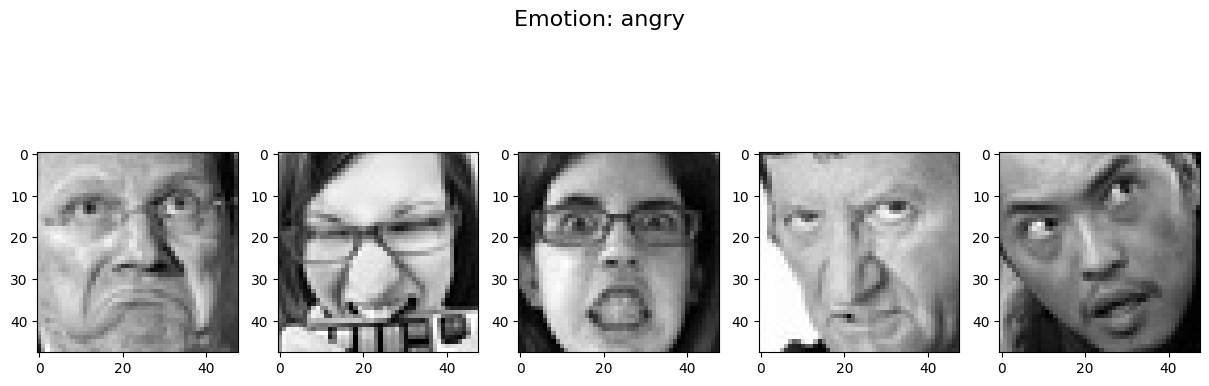

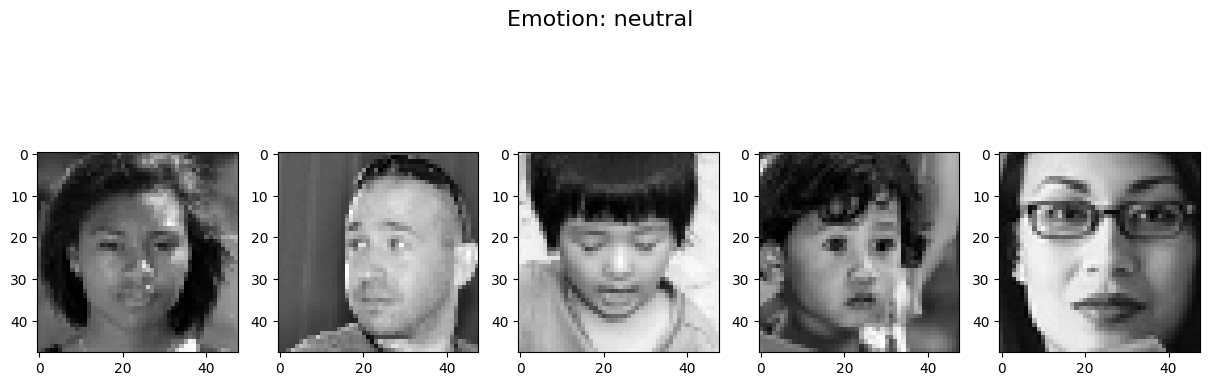

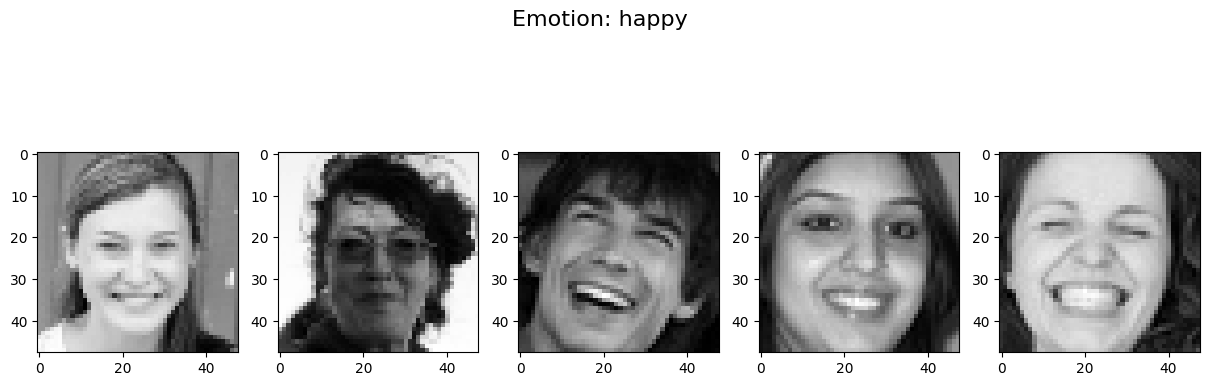

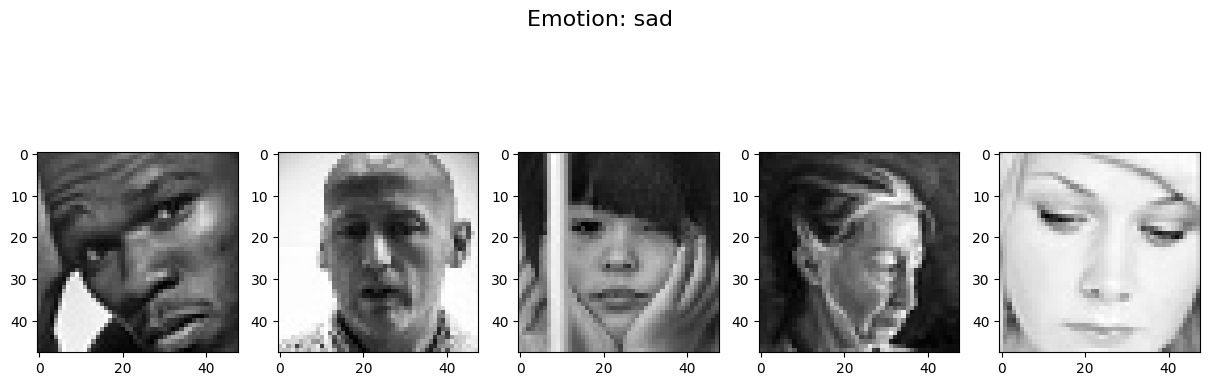

In [12]:
# Visualize images

def show_images_from_dataset(dataset_dir, num_images=5):
    emotions = os.listdir(dataset_dir)
    for emotion in emotions:
      if emotion[0] != '.': #skip hidden files
          emotion_dir = os.path.join(dataset_dir, emotion)
          img_names = os.listdir(emotion_dir)
          random.shuffle(img_names)

          plt.figure(figsize=(15, 5))
          plt.suptitle(f'Emotion: {emotion}', fontsize=16)

          for i in range(num_images):
              img_path = os.path.join(emotion_dir, img_names[i])
              img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
              if img is not None:
                  plt.subplot(1, num_images, i + 1)
                  plt.imshow(img, cmap='gray')

          plt.show()



show_images_from_dataset(train_dir)

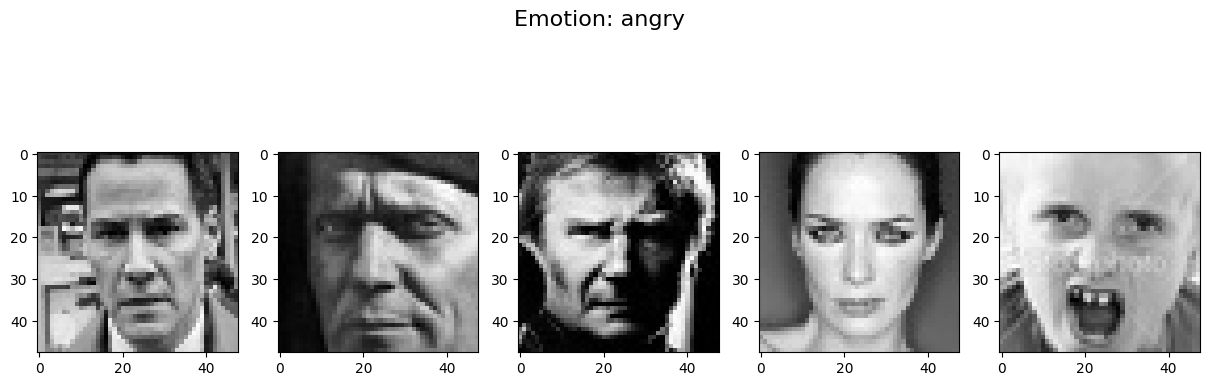

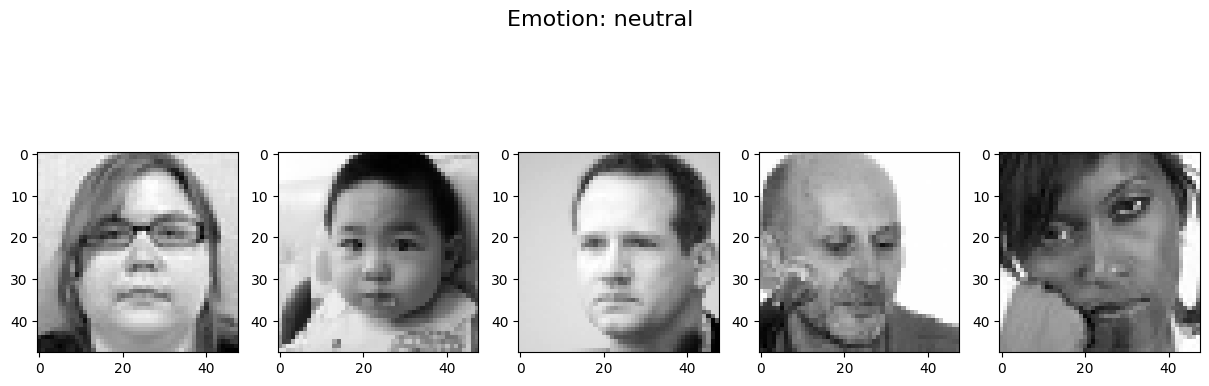

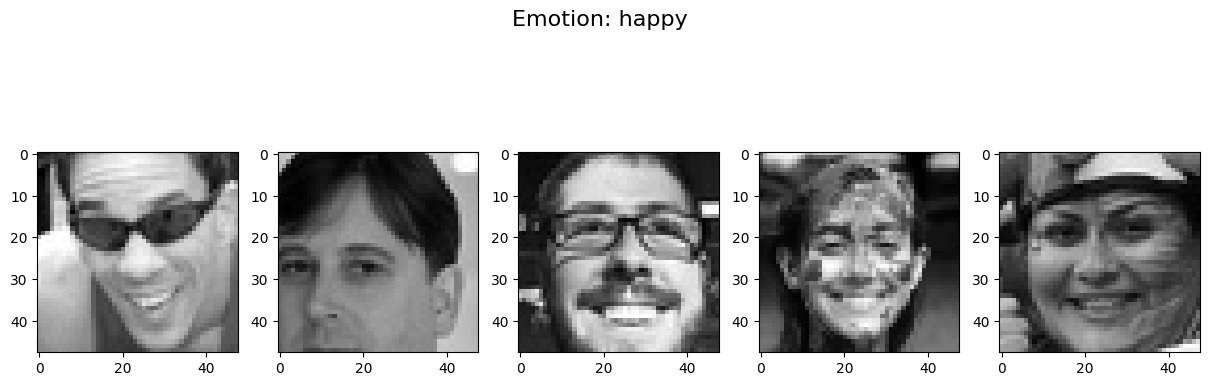

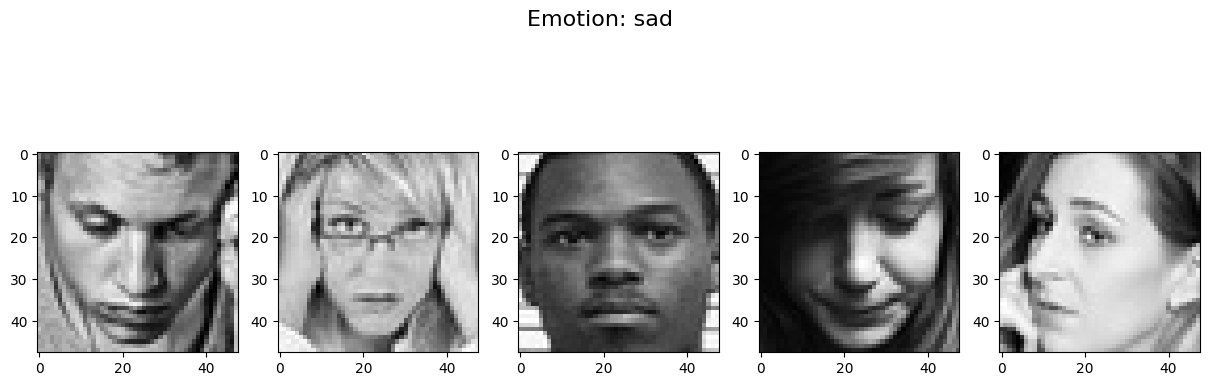

In [13]:
show_images_from_dataset(test_dir)

# ***8. Preprocessing the Combined Dataset***



*   Shape and batch size are defined
*   Images are normalized. (1 / 255)
*   Data augmentation applied.
*   Train set are shuffled. No need to shuffle test set.

In [14]:
img_shape = 224
batch_size = 64

train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)


test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 34186 images belonging to 4 classes.
Found 8510 images belonging to 4 classes.


##Custom CNN


In [15]:
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

precision = Precision()
recall = Recall()


In [ ]:
classes = ['happy', 'neutral', 'anger', 'sad']

class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

print("Class counts before balancing:")
print(class_counts)

In [35]:
import os

data_dir = '/content/affectnet_preprocessed/train'
classes = ['happy', 'neutral', 'angry', 'sad']

class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

print("Class counts before balancing:")
print(class_counts)


Class counts before balancing:
{'happy': 4035, 'neutral': 4100, 'angry': 2574, 'sad': 2472}


In [36]:
import random
from shutil import copyfile

min_class_count = min(class_counts.values())

# Create a new directory for balanced data
balanced_dir = '/content/affectnet_preprocessed/balanced_train'
os.makedirs(balanced_dir, exist_ok=True)

for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    images = os.listdir(cls_dir)
    random.shuffle(images)

    selected_images = images[:min_class_count]  # Downsample to match the smallest class size

    # Create a directory for the class in the balanced dataset
    cls_balanced_dir = os.path.join(balanced_dir, cls)
    os.makedirs(cls_balanced_dir, exist_ok=True)

    for img in selected_images:
        src = os.path.join(cls_dir, img)
        dst = os.path.join(cls_balanced_dir, img)
        copyfile(src, dst)

print(f"Balanced dataset created at {balanced_dir}")


Balanced dataset created at /content/affectnet_preprocessed/balanced_train


In [37]:
balanced_class_counts = {cls: len(os.listdir(os.path.join(balanced_dir, cls))) for cls in classes}

print("Class counts after balancing:")
print(balanced_class_counts)


Class counts after balancing:
{'happy': 2472, 'neutral': 2472, 'angry': 2472, 'sad': 2472}


In [39]:
data_dir = balanced_dir  # Update the data directory to the balanced dataset
print(data_dir)

/content/affectnet_preprocessed/balanced_train


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Load and preprocess your dataset
# Assuming your images are organized in directories by class, e.g., `happy/`, `sad/`, etc.

def load_data(image_size=(64, 64)):
    data_dir = "/content/affectnet_preprocessed/train"  # Change this to your dataset path
    datagen = ImageDataGenerator(rescale=1./255)

    data = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    X, y = zip(*(data[i] for i in range(len(data))))
    X = np.vstack(X)
    y = np.vstack(y)

    return X, y

# Load data
image_size = (64, 64)  # Resizing images to 64x64 to reduce computation
X, y = load_data(image_size=image_size)

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom CNN model
def create_custom_cnn(input_shape=(64, 64, 3), num_classes=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.1),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create the model
num_classes = 4  # Since we're using 4 emotions: happy, sad, neutral, and anger
model = create_custom_cnn(input_shape=(image_size[0], image_size[1], 3), num_classes=num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',precision,recall])

# Display the model summary
model.summary()

# Set up callbacks for early stopping and saving the best model
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Train the model with a smaller batch size to prevent memory overload
batch_size = 32
epochs = 50

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)




Found 13181 images belonging to 4 classes.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 504,132 (1.92 MB)

 Trainable params: 503,876 (1.92 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 135s 396ms/step - accuracy: 0.3802 - loss: 1.4284 - precision: 0.4162 - recall: 0.1189 - val_accuracy: 0.5427 - val_loss: 1.0609 - val_precision: 0.9684 - val_recall: 0.1858
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 138s 383ms/step - accuracy: 0.7107 - loss: 0.6240 - precision: 0.7381 - recall: 0.6670 - val_accuracy: 0.7789 - val_loss: 0.4910 - val_precision: 0.8033 - val_recall: 0.7512
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 139s 375ms/step - accuracy: 0.7522 - loss: 0.5483 - precision: 0.7708 - recall: 0.7235 - val_accuracy: 0.7478 - val_loss: 0.5709 - val_precision: 0.7541 - val_recall: 0.7338
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 144s 382ms/step - accuracy: 0.7836 - loss: 0.4906 - precision: 0.7986 - recall: 0.7645 - val_accuracy: 0.7998 - val_loss: 0.4681 - val_precision: 0.8057 - val_recall: 0.7880
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 141s 378ms/step - accuracy: 0.8060 - loss: 0.4692 - precision: 0.8159 - recall: 0.7899 - val_accuracy: 0

ValueError: too many values to unpack (expected 2)

In [24]:
# Evaluate the model on the validation set
results = model.evaluate(x_val, y_val)
val_loss, val_accuracy = results[0], results[1]  # Adjust according to the number of metrics

# If you used additional metrics like precision and recall:
if len(results) == 3:
    val_precision = results[2]
    print(f"Validation Precision: {val_precision * 100:.2f}%")
elif len(results) == 4:
    val_recall = results[3]
    print(f"Validation Recall: {val_recall * 100:.2f}%")

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.8245 - loss: 0.3926 - precision: 0.8306 - recall: 0.8223
Validation Recall: 82.86%
Validation Loss: 0.3918507397174835
Validation Accuracy: 83.35%


In [25]:
# For example, if you added precision and recall:
results = model.evaluate(x_val, y_val)
val_loss, val_accuracy, val_precision, val_recall = results

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Precision: {val_precision * 100:.2f}%")
print(f"Validation Recall: {val_recall * 100:.2f}%")


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8245 - loss: 0.3926 - precision: 0.8306 - recall: 0.8223
Validation Loss: 0.3918507397174835
Validation Accuracy: 83.35%
Validation Precision: 84.10%
Validation Recall: 82.86%


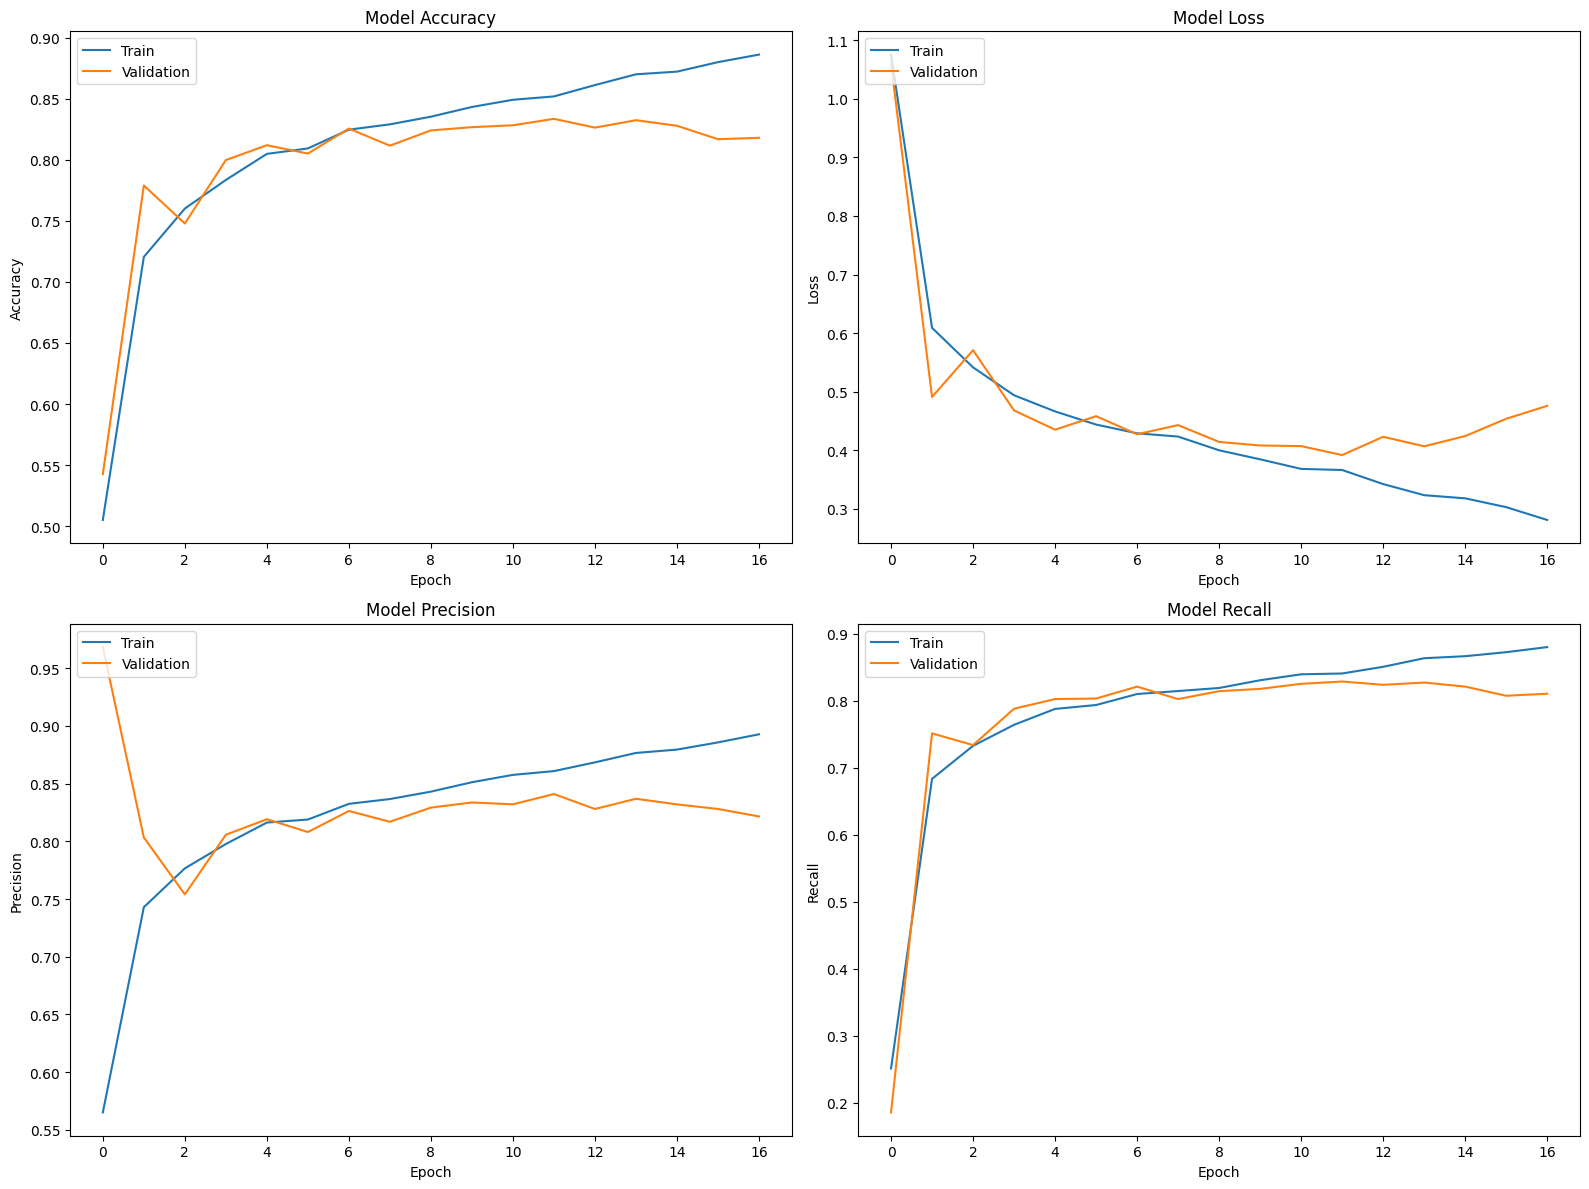

In [43]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation precision values
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation recall values
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show plots
plt.tight_layout()
plt.show()


In [28]:
# 1. Save the model
model.save('face_emotion_recognition_model2.h5')

# 2. Load the model (for future use)
from tensorflow.keras.models import load_model # Import the load_model function
model = load_model('face_emotion_recognition_model2.h5')
model.summary()

# 3. Download the model to your local system
from google.colab import files
files.download('face_emotion_recognition_model2.h5')

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 504,134 (1.92 MB)

 Trainable params: 503,876 (1.92 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 2 (12.00 B)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


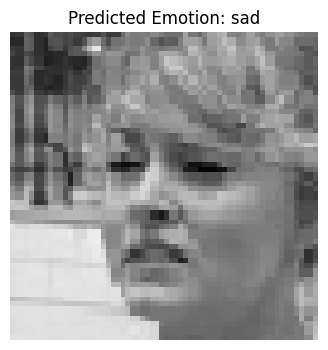

In [32]:
# Load a new image and preprocess it
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load a new image and preprocess it
img_path = '/content/affectnet_preprocessed/test/sad/image0000118.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0

# Predict the emotion
predictions = model.predict(img_array_expanded)
predicted_class = np.argmax(predictions, axis=1)

class_labels = ['happy', 'neutral', 'anger', 'sad']
predicted_label = class_labels[predicted_class[0]]

# Display the image along with the predicted label
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Hide the axes
plt.show()


In [30]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step
              precision    recall  f1-score   support

       happy       0.73      0.71      0.72       493
     neutral       0.93      0.88      0.90       814
       anger       0.88      0.91      0.89       828
         sad       0.71      0.76      0.73       502

    accuracy                           0.83      2637
   macro avg       0.81      0.81      0.81      2637
weighted avg       0.84      0.83      0.83      2637



# ***12. Create Callbacks***



*   Save the model weights with best accuracy
*   ***Early stopping mechanism:*** If validation accuracy doesn't get better within 7 epochs, stop fitting.
* ***Reduce LR:*** If validation loss doesn't get better within 2 epochs, reduce the learning rate by factor 0.2 in order to train a stable and more precise model.



# ***15. Plot the Curves***



*   Training and Validation Loss curves
*   Accuracy curves
*   Precision and Recall curves


# ***16. Final Metrics***

83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step


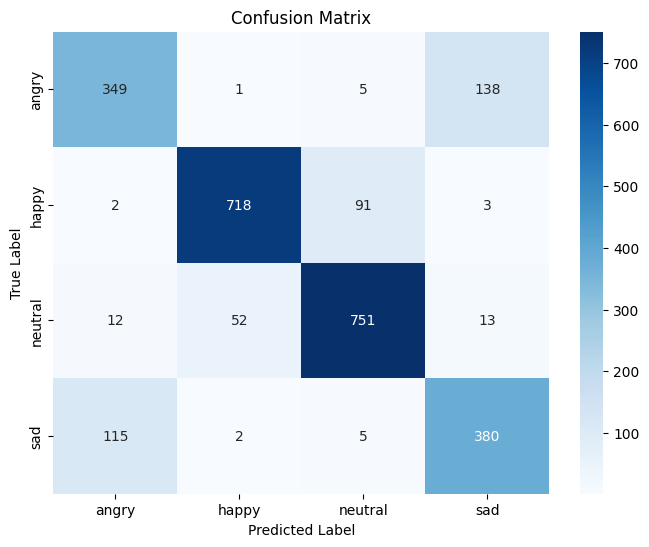

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Make predictions on the validation set
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# 2. Convert true labels to class indices
y_val_classes = np.argmax(y_val, axis=1)  # Convert true labels to class indices

# 3. Compute the confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# 4. Plot the confusion matrix
labels = ['angry', 'happy', 'neutral', 'sad']  # List of class labels

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [45]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 8510 images belonging to 4 classes.


# ***17. Visualize Predictions***

# ***18. Load Haar Cascade for Face Detection***

In [46]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

--2024-08-18 22:07:43--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.08s   

2024-08-18 22:07:44 (10.6 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



# ***18. Predict different images from local***

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


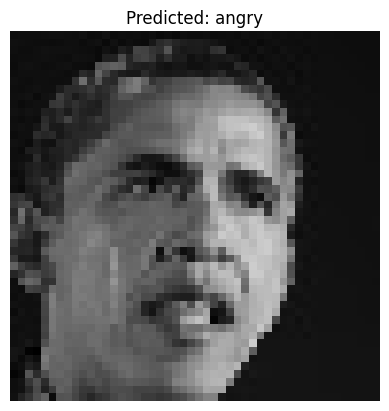

Predicted Label: angry
Prediction Probabilities: [0.5067309  0.00132849 0.00353324 0.4884074 ]


In [48]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('best_model.keras')

# Define the class labels
labels = ['angry', 'happy', 'neutral', 'sad']

def preprocess_image(img_path, target_size=(64, 64)):
    """Load and preprocess an image."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch dimension
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

def predict_image(img_path):
    """Predict the class of an image."""
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    return labels[predicted_class], predictions[0]

def display_image_with_prediction(img_path, predicted_label):
    """Display the image with the predicted label."""
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

# Path to the local image
img_path = '/content/affectnet_preprocessed/balanced_train/angry/image0000602.jpg'  # Update with the path to your image

# Predict and display the result
predicted_label, prediction_prob = predict_image(img_path)
display_image_with_prediction(img_path, predicted_label)

print(f'Predicted Label: {predicted_label}')
print(f'Prediction Probabilities: {prediction_prob}')
